### Part 3.2 - Model 3: English Google News 130GB corpus without OOV tokens (latest changes on 08.02.2020)

#### Import the libraries

In [1]:
# For cleaning and preparing the dataset
# -> dataframe manipulation
# -> text manipulation
# -> Web Scrapping

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tabulate import tabulate
import re

import random

# Module to serialize the content produced from the execution of the code

import pickle

# Module to monitor the progress of a python for loop

from tqdm import tqdm_notebook

# Module to manipulate text in python - NLTK package

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Module to compute word vectorizers and compute the cosine distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

import string
import itertools

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

#### Keras Text Classification (For creating the word embeddings)

In [2]:
from nltk.stem import WordNetLemmatizer

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from time import time

#--------------------------------------------------------------

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#---------------------------------------------------------------

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from pylab import rcParams

import pydot
import pydotplus
import graphviz

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json

# Import ML FLow
import mlflow.tensorflow
import mlflow.pyfunc
from tensorflow.keras import regularizers
import datetime

# Import TensorBoard
import tensorflow_docs as tfdocs
import tensorflow_docs.plots as tfplots
import tensorflow_docs.modeling as tfmodel
from tensorflow.keras import regularizers
# from tensorboard import default
# from tensorboard import program

import tensorflow_hub as hub
import bert
from bert import tokenization
from bert.tokenization import FullTokenizer

#Visualize Model

def visualize_model(model):
    return SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

from tensorflow.keras.utils import plot_model

from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version:  2.1.0
Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


#### Import the dataset

In [3]:
dataset_frequent_genres = pd.read_pickle('dataset_part_2_05022020.pkl')

print("\nThe shape of the dataset that will be used in Keras classifier is: {}".format(dataset_frequent_genres.shape))

# Split the y variable ("genres") to one hot encoded columns
mlb = MultiLabelBinarizer()
dataset_frequent_genres = dataset_frequent_genres.join(pd.DataFrame(mlb.fit_transform(dataset_frequent_genres['reduced_genres']),
                                                                    columns=mlb.classes_,
                                                                    index=dataset_frequent_genres.index))


The shape of the dataset that will be used in Keras classifier is: (49123, 13)


In [4]:
# Function 1: Actors
def unify_actors(row):
    return ', '.join(row['actors'])

In [5]:
dataset_frequent_genres.loc[:, 'reviews_pruned'] = dataset_frequent_genres.reviews.apply(lambda x: x[0])
dataset_frequent_genres['actors_unified'] = dataset_frequent_genres.apply(unify_actors, axis=1)

table = str.maketrans(dict.fromkeys(string.punctuation))
dataset_frequent_genres.loc[:, 'reviews_pruned'] = dataset_frequent_genres.loc[:, 'reviews_pruned'].apply(lambda x: x.translate(table))

In [6]:
dataset_frequent_genres.columns

Index(['title', 'genres', 'rating', 'imdb_url', 'reviews_url', 'actors',
       'plot', 'imdb_rating', 'director', 'reviews', 'sentiment_value',
       'movie_features', 'reduced_genres', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'reviews_pruned', 'actors_unified'],
      dtype='object')

#### Functions

In [7]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

class Keras_Configurations_model1():
    
        MAX_FEATURES = 20000

class Keras_Configurations_model2():

    MAX_FEATURES = 17500
    
class Keras_Configurations_model3():
        
        MAX_FEATURES = 20000

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 1

def preprocess_text(text):
    
    stop_words = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()
    
    no_stopword_text = [word for word in text.split(' ') if not word in stop_words]
    
    lemmatized_text = [lemmatizer.lemmatize(word, pos='v') for word in no_stopword_text]
    
    lowercase_text = [word.lower() for word in lemmatized_text]
    
    return ' '.join(lowercase_text)

def transform_actors(actors_column, dataset):
    
        actors_list = []

        for i in range(len(actors_column)):
            actors_list.append([element.lower() for element in actors_column.iloc[i]])

        dataset.loc[:, 'clean_actors'] = actors_list

    # dataset.loc[:, 'clean_actors'] = dataset.loc[:, column_name].apply(lambda x: x.lower())

def transform_plot(column_name, dataset):
    
    stop_words = set(stopwords.words('english'))

    lemmatizer = WordNetLemmatizer()
    
    dataset.loc[:, 'clean_plot_summary'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))

def transform_features(column_name, dataset):
    
    dataset.loc[:, 'clean_combined_features'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))
    
def transform_reviews(column_name, dataset):
    
    dataset.loc[:, 'clean_reviews'] = dataset.loc[:, column_name].apply(lambda x: preprocess_text(x))

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Function 2
def split_dataset(labels, dataset):
    
    X = dataset[['title', 'clean_actors', 'clean_plot_summary', 'clean_combined_features', 'clean_reviews', 'reduced_genres']]
    
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle= True)
    
    return X_train, X_test, y_train, y_test

In [8]:
%%time
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Transfrom the columns
print("---------------------------------------------------------------------------------\n")
print("Transfrom the column of the actors\n")
transform_actors(dataset_frequent_genres.loc[:, 'actors'], dataset_frequent_genres) # function 3: transform_actors

print("Transfrom the column of the plot summary\n")
transform_plot("plot", dataset_frequent_genres) # function 3: transform_plot

print("Transfrom the column of the movie features\n")
transform_features("movie_features", dataset_frequent_genres) # function 3: transform_features

print("Transfrom the column of the movie reviews\n")
transform_reviews("reviews_pruned", dataset_frequent_genres) # function 3: transform_reviews

---------------------------------------------------------------------------------

Transfrom the column of the actors

Transfrom the column of the plot summary

Transfrom the column of the movie features

Transfrom the column of the movie reviews

Wall time: 1min 12s


In [9]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Split the dataset into train & validation set
print("\n---------------------------------------------------------------------------------")
print("\nSplit the dataset into train & validation set\n")

X_train, X_test, y_train, y_test = split_dataset(dataset_frequent_genres.iloc[:, 13:30], dataset_frequent_genres) #13:30

print("X_train shape:{}".format(X_train.shape))
print("X_test shape:{}".format(X_test.shape))
print("y_train shape:{}".format(y_train.shape))
print("y_test shape:{}".format(y_test.shape))


---------------------------------------------------------------------------------

Split the dataset into train & validation set

X_train shape:(39298, 6)
X_test shape:(9825, 6)
y_train shape:(39298, 17)
y_test shape:(9825, 17)


In [10]:
%%time
# Separate each different input column (actors, plot, features)

# BECAREFUL: X_train = before balancing the data, X_train_updated_version2 is for the balanced data

X_train_actors = X_train[["title", "clean_actors", "reduced_genres"]]
X_train_plot = X_train[["title", "clean_plot_summary", "reduced_genres"]]
X_train_features = X_train[["title", "clean_combined_features", "reduced_genres"]]
X_train_reviews = X_train[["title", "clean_reviews", "reduced_genres"]]
# In X_train and X_test I also use columns "title" and "genres" since they will be both used later for making inference with predictions

assert X_train_actors.shape==X_train_plot.shape==X_train_features.shape==X_train_reviews.shape

X_test_actors = X_test[["title", "clean_actors", "reduced_genres"]]
X_test_plot = X_test[["title", "clean_plot_summary", "reduced_genres"]]
X_test_features = X_test[["title", "clean_combined_features", "reduced_genres"]]
X_test_reviews = X_test[["title", "clean_reviews", "reduced_genres"]]

assert X_test_actors.shape==X_test_plot.shape==X_test_features.shape==X_test_reviews.shape

Wall time: 14 ms


# <b>- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  </b>

#### Multiple Input

In [11]:
train_text_features = X_train_features['clean_combined_features'].tolist() #input 1
test_text_features = X_test_features['clean_combined_features'].tolist()

train_text_plot = X_train_plot['clean_plot_summary'].tolist() #input 2
test_text_plot = X_test_plot['clean_plot_summary'].tolist()

train_text_actors = X_train_actors['clean_actors'].tolist() #input 3
test_text_actors = X_test_actors['clean_actors'].tolist()

train_text_reviews = X_train_reviews['clean_reviews'].tolist() #input 4
test_text_reviews = X_test_reviews['clean_reviews'].tolist()

train_label = y_train.values
test_label = y_test.values

train_bytes_list_features = []
train_bytes_list_plot = []
train_bytes_list_actors = []
train_bytes_list_reviews = []

# actor_list = []

test_bytes_list_features = []
test_bytes_list_plot = []
test_bytes_list_actors = []
test_bytes_list_reviews = []

for i in train_text_features:
    train_bytes_list_features.append(str.encode(i))
for i in train_text_plot:
    train_bytes_list_plot.append(str.encode(i))
for i in train_text_actors:
    train_bytes_list_actors.append(list(map(lambda x: str.encode(x), i)))
for i in train_text_reviews:
    train_bytes_list_reviews.append(str.encode(i))

for i in test_text_features:
    test_bytes_list_features.append(str.encode(i))
for i in test_text_plot:
    test_bytes_list_plot.append(str.encode(i))
for i in test_text_actors:
    test_bytes_list_actors.append(list(map(lambda x: str.encode(x), i)))
for i in test_text_reviews:
    test_bytes_list_reviews.append(str.encode(i))

train_bytes_list_features = np.asarray(train_bytes_list_features)
train_bytes_list_plot = np.asarray(train_bytes_list_plot)
train_bytes_list_actors = np.asarray(train_bytes_list_actors)
train_bytes_list_reviews = np.asarray(train_bytes_list_reviews)

test_bytes_list_features = np.asarray(test_bytes_list_features)
test_bytes_list_plot = np.asarray(test_bytes_list_plot)
test_bytes_list_actors = np.asarray(test_bytes_list_actors)
test_bytes_list_reviews = np.asarray(test_bytes_list_reviews)

partial_x_train_features, x_val_features, partial_y_train, y_val = train_test_split(train_bytes_list_features, train_label, test_size=0.20, random_state=42)
partial_x_train_plot, x_val_plot, partial_y_train, y_val = train_test_split(train_bytes_list_plot, train_label, test_size=0.20, random_state=42)
partial_x_train_actors, x_val_actors, partial_y_train, y_val = train_test_split(train_bytes_list_actors, train_label, test_size=0.20, random_state=42)
partial_x_train_reviews, x_val_reviews, partial_y_train, y_val = train_test_split(train_bytes_list_reviews, train_label, test_size=0.20, random_state=42)

In [12]:
print(x_val_features[0],"\n")
print(x_val_plot[0], "\n")
print(x_val_actors[0], "\n")
print(x_val_reviews[0], "\n")

b'money pit, tom hanks shelley long alexander godunov maureen stapleton joe mantegna philip bosco josh mostel yakov smirnoff carmine caridi brian backer billy lombardo mia dillon john van dreelen douglass watson lucille dobrin richard benjamin young couple struggle repair hopelessly dilapidate house comedy' 

b'a young couple struggle repair hopelessly dilapidate house' 

[b'tom hanks', b'shelley long', b'alexander godunov', b'maureen stapleton', b'joe mantegna', b'philip bosco', b'josh mostel', b'yakov smirnoff', b'carmine caridi', b'brian backer', b'billy lombardo', b'mia dillon', b'john van dreelen', b'douglass watson', b'lucille dobrin'] 

b'i know critics rip the money pit get release they apparently didnt realize wasnt pretend masterpiece big excuse funny succeed some gag seem forecast equally funny mousehunt personally i think tom hanks need act comedies shelley long need get roles movies my favorite scene well i get giggle whenever i think whole chain reaction just kinds things

#### Token based text embedding trained on English Google News 130GB corpus. (without OOV tokens)

#### Python Cell no.1
--------------------------

In this below python cell I create 2 functions, which will save my model and will stop it early in case the results do not improve any further. More specifically, the <b>callback function</b> is very usefull when someone wants to test the <i>overfitting boundaries</i> of a neural network. Each time the fitting of the model achieves a better value of the monitored metric (e.g val_loss) then the model is automatically saved. On the contrary, if during the epoch fitting the model reaches a worse state than the previous epoch then the training of the model automatically stops.

In [13]:
%load_ext tensorboard
# %reload_text tensorboard

logdir=".\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Callback function with early stopping to avodid overfit

class Callback_Configurations():
    
    MONITOR_METRIC = 'val_loss'
    MINIMUM_DELTA = 1
    PATIENCE = 5
    VERBOSE = 0
    MODE = 'min'
    
def callback(saved_model, model, logdir):
    
    weights_fname = '{}.h5'.format(saved_model)

    try:
        with open('{}.json'.format(save_model),'r') as f:
            model_json = json.load(f)
        
        model = model_from_json(model_json)
        
        model.load_weights('{}').format(weights_fname)

    except:
        print('\nPre-trained weights not found. Fitting from start')
        pass

    monitor_metric = Callback_Configurations.MONITOR_METRIC
    
    callbacks = [
        tfmodel.EpochDots(),
        
        EarlyStopping(monitor=monitor_metric,
                      min_delta=Callback_Configurations.MINIMUM_DELTA,
                      patience=Callback_Configurations.PATIENCE,
                      verbose=Callback_Configurations.VERBOSE,
                      mode=Callback_Configurations.MODE,
                      restore_best_weights=True),

        ModelCheckpoint(filepath=weights_fname,
                        monitor=monitor_metric,
                        verbose=Callback_Configurations.VERBOSE,
                        save_best_only=True,
                        save_weights_only=True), #True, False
        
        tf.keras.callbacks.TensorBoard(logdir)
        
]
    return callbacks

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def save_model(model, model_name):
    
    model_json = model.to_json()

    with open("{}.json".format(model_name), "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights("{}.h5".format(model_name))
    
    print("\nModel's weights are saved")
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def plot_model_metrics(fit_model):

    rcParams['figure.figsize'] = 10, 5

    plt.plot(fit_model.history['sparse_categorical_accuracy'] , 'g') # acc
    plt.plot(fit_model.history['val_sparse_categorical_accuracy'] , 'b') # val_acc
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

    rcParams['figure.figsize'] = 10, 5

    plt.plot(fit_model.history['loss'] , 'g')
    plt.plot(fit_model.history['val_loss'] , 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def plot_keras_history(history): #where history =  model.fit()
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

#### Python Cell no.2
------------------------------

In this below python cell I keep track of the model parameters used to:

* create the neural network model,
* to fit the neural network,
* to optimize the neural network.

Storing the values of the parameters to a dictionary, I could then change dynamically the value of a parameter, rerun the neural model and then monitor the difference in the results.

In [14]:
# Neural Network Logging parameters

neural_network_parameters = {}
optimizer_parameters = {}
fit_parameters = {}

# Create the neural network
neural_network_parameters['embedding_dimension'] = 50
neural_network_parameters['pool_size'] = None
neural_network_parameters['padding'] = 'valid'
neural_network_parameters['batch_size'] = 64
neural_network_parameters['l2_regularization'] = 0.01
neural_network_parameters['dropout_rate'] = 0.0
neural_network_parameters['dense_activation'] = 'relu'
neural_network_parameters['output_activation'] = 'sigmoid'
neural_network_parameters['model_loss'] = "binary_crossentropy" #'sparse_categorical_crossentropy'
neural_network_parameters['model_metric'] = "accuracy" #'sparse_categorical_accuracy'
#--------------------------------------------------------------------------------------

# Fit the neural network
fit_parameters["steps_per_epoch"] = len(partial_x_train_features)//neural_network_parameters['batch_size']
fit_parameters["epoch"] = 150
fit_parameters["verbose_fit"] = 0
fit_parameters["batch_size_fit"] = 64

#---------------------------------------------------------------------------------------

# Optimize the neural network

# Optimizer: ADAM (version_1)
optimizer_parameters['adam_learning_rate'] = 0.001
optimizer_parameters['adam_beta_1'] = 0.99
optimizer_parameters['adam_beta_2'] = 0.999
optimizer_parameters['adam_amsgrad'] = False

def optimizer_adam_v1():
    
    return keras.optimizers.Adam(learning_rate=optimizer_parameters['adam_learning_rate'], 
                                 beta_1=optimizer_parameters['adam_beta_1'], 
                                 beta_2=optimizer_parameters['adam_beta_2'], 
                                 amsgrad=optimizer_parameters['adam_amsgrad'])
#---------------------------------------------------------------------------------------

# Optimizer: ADAM (version_2)
optimizer_parameters['steps_per_epoch'] = len(partial_x_train_features)//neural_network_parameters['batch_size']
optimizer_parameters['lr_schedule_learning_rate'] = 0.01
optimizer_parameters['lr_schedule_decay_steps'] = optimizer_parameters['steps_per_epoch']*1000
optimizer_parameters['lr_schedule_decay_rate'] = 1
optimizer_parameters['staircase'] = False

#STEPS_PER_EPOCH = len(X_train_seq_features)//neural_network_parameters['batch_size'] #(512 = BATCH SIZE)
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    optimizer_parameters['lr_schedule_learning_rate'],
    decay_steps=optimizer_parameters['lr_schedule_decay_steps'],
    decay_rate=optimizer_parameters['lr_schedule_decay_rate'],
    staircase=optimizer_parameters['staircase'])

def optimizer_adam_v2():
    
    return keras.optimizers.Adam(lr_schedule)
#---------------------------------------------------------------------------------------

# Optimizer: SDG (version 1)

optimizer_parameters['SGD_learning_rate'] = 0.01
optimizer_parameters['SGD_decay'] = 1e-6
optimizer_parameters['SGD_momentum'] = 0.9
optimizer_parameters['SGD_nesterov'] = True

def optimizer_SDG_v1():
    
    return keras.optimizers.SGD(lr=optimizer_parameters['SGD_learning_rate'],
                                decay=optimizer_parameters['SGD_decay'],
                                momentum=optimizer_parameters['SGD_momentum'],
                                nesterov=optimizer_parameters['SGD_nesterov'])

#---------------------------------------------------------------------------------------

#### Python Cell no.3
------------------------------

In the python cell below, I run MLFLOW program to train, fit, save and log the parameters, weights of the neural network.
The code below is splitted into different parts indicated by short-name subtitle (<i>e.g import the pre-trained model</i>, <i>create the model structure</i>, <i>fit the model, etc.</i>).



Model: "English_Google_News_130GB_witout_OOV_tokens"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1105      
Total params: 402,469
Trainable params: 402,469
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\spano\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\training\tracking\data_structures.py:720: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):



Pre-trained weights not found. Fitting from start

Epoch: 0, accuracy:0.9373,  loss:0.1972,  val_accuracy:0.9707,  val_loss:0.1051,  
......
Table of training the keras text classification model

+----+-----------+------------+------------+----------------+---------+
|    |      loss |   accuracy |   val_loss |   val_accuracy |   epoch |
|----+-----------+------------+------------+----------------+---------|
|  1 | 0.197205  |   0.937333 |  0.1051    |       0.970731 |       1 |
|  2 | 0.0826482 |   0.97863  |  0.0711013 |       0.982316 |       2 |
|  3 | 0.0588281 |   0.986485 |  0.0603429 |       0.985099 |       3 |
|  4 | 0.0479412 |   0.989606 |  0.0528831 |       0.988033 |       4 |
|  5 | 0.0410108 |   0.991352 |  0.0494942 |       0.988864 |       5 |
|  6 | 0.037519  |   0.992119 |  0.047127  |       0.988894 |       6 |
+----+-----------+------------+------------+----------------+---------+
9825/9825 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9

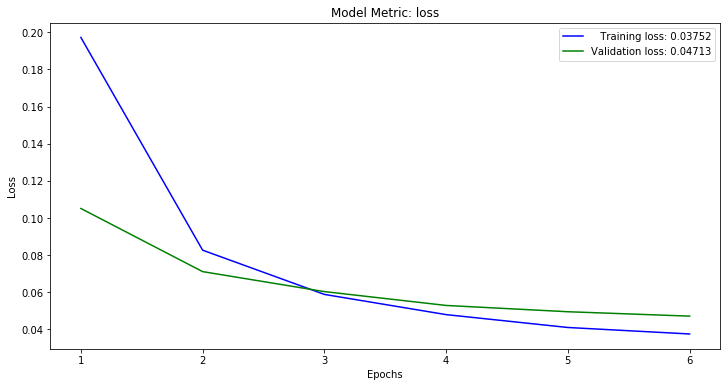

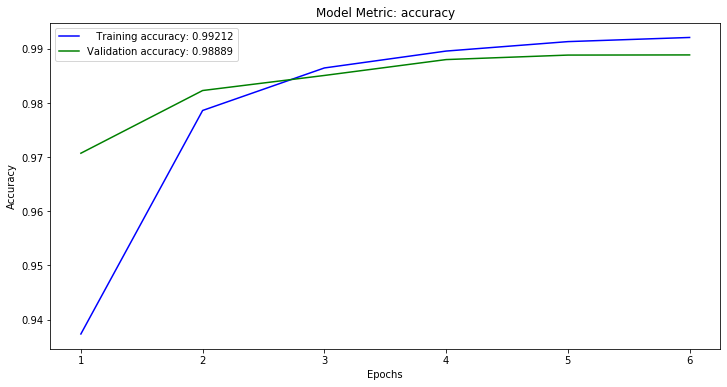

Using TensorFlow backend.


In [15]:
with mlflow.start_run():
    
    # import the pre-trained model
    model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
    hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)
    
    # create the model structure
    model = tf.keras.Sequential(name="English_Google_News_130GB_witout_OOV_tokens")
    model.add(hub_layer)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(neural_network_parameters['batch_size'],
                                    kernel_regularizer=regularizers.l2(neural_network_parameters['l2_regularization']),
                                    activation=neural_network_parameters['dense_activation']))
    model.add(tf.keras.layers.Dropout(neural_network_parameters['dropout_rate']))
    model.add(tf.keras.layers.Dense(y_val.shape[1], activation=neural_network_parameters['output_activation']))

    print("\n")
    print(model.summary())

    optimizer = optimizer_adam_v2()

    model.compile(optimizer=optimizer,
                  loss=neural_network_parameters['model_loss'],
                  metrics=[neural_network_parameters['model_metric']])
    
    plot_model(model, to_file='google_news_20dim.png')
    
    logdir = ".\\logs_test\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    # fit the model
    history = model.fit([partial_x_train_features, partial_x_train_plot, partial_x_train_actors, partial_x_train_reviews],
                        partial_y_train,
                        epochs=fit_parameters["epoch"],
                        batch_size=fit_parameters["batch_size_fit"],
                        validation_data=([x_val_features, x_val_plot, x_val_actors, x_val_reviews], y_val),
                        verbose=fit_parameters["verbose_fit"],
                        callbacks=callback("google_news_20dim_noOOVtokens", model, logdir))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    # plot the model's progress per epoch
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['epoch']+= 1
    hist.index += 1
    print("\nTable of training the keras text classification model\n")
    print(tabulate(hist, headers='keys', tablefmt='psql'))
    
    hist.to_pickle(".\\model_three\\metrics_histogram_google_news_130GB_noOOVtokens_08022020.pkl")
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    # evaluate the model
    model_evaluation = model.evaluate([test_bytes_list_features, test_bytes_list_plot, test_bytes_list_actors, test_bytes_list_reviews], test_label)

    print('\nTest Score:', model_evaluation[0])

    print('\nTest Accuracy:', model_evaluation[1])

    print(model_evaluation)
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    # save the model
    save_model(model, "google_news_20dim")
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    #plot_model_metrics(history)
    plot_keras_history(history)
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    # Log model parameters and metrics
    #neural_model params
    mlflow.log_param("batch_size", neural_network_parameters['batch_size'])
    mlflow.log_param("l2_regularization", neural_network_parameters['l2_regularization'])
    mlflow.log_param("dropout_rate", neural_network_parameters['dropout_rate'])
    mlflow.log_param("dense_activation", neural_network_parameters['dense_activation'])
    mlflow.log_param("output_activation",neural_network_parameters['output_activation'])
    mlflow.log_param("model_loss",neural_network_parameters['model_loss']) #takes any data type
    mlflow.log_param("model_metric",neural_network_parameters['model_metric'])
    
    #optimizer params
    mlflow.log_param("lr_schedule_learning_rate",optimizer_parameters['lr_schedule_learning_rate'])
    mlflow.log_param("lr_schedule_decay_steps",optimizer_parameters['lr_schedule_decay_steps'])
    mlflow.log_param("lr_schedule_decay_rate",optimizer_parameters['lr_schedule_decay_rate'])
    mlflow.log_param("adam_amsgrad",optimizer_parameters['staircase'])
    
    #fit_model params
    #mlflow.log_param("steps_per_epoch",fit_parameters['steps_per_epoch'])
    mlflow.log_param("fit_epoch",fit_parameters['epoch'])
    mlflow.log_param("verbose_fit",fit_parameters['verbose_fit'])
    mlflow.log_param("batch_size_fit",fit_parameters['batch_size_fit']) #in generl batch_size_fit = neurons batch size
    
    #logging the model metrics
    mlflow.log_metric("model_validation_loss",model_evaluation[0]) #take only floats/integers
    mlflow.log_metric("model_validation_accuracy",model_evaluation[1])
    
    mlflow.keras.log_model(model, "google_news_20dim")

#     mlflow.tensorflow.save_model(model, model_dir_path)

In [21]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict([test_bytes_list_features, test_bytes_list_plot, test_bytes_list_actors, test_bytes_list_reviews])
y_test_pred_probs[0]

y_test_predictions = (y_test_pred_probs>0.5).astype(int)
y_test=test_label
# y_predicted probabilities for each class

In [22]:
np.save(".//model_three//y_predictions_google_news_130GB_noOOVtokens_08022020", y_test_predictions)
np.save(".//model_three//y_true_google_news_130GB_noOOVtokens_08022020", y_test)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report


classification_report= classification_report(y_true=y_test,
                                             y_pred=y_test_predictions)
print(classification_report)

c:\users\spano\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\spano\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1363
           1       0.83      0.63      0.72       774
           2       0.83      0.76      0.79       415
           3       0.78      0.53      0.63       438
           4       0.98      0.97      0.97      2835
           5       0.89      0.83      0.86       988
           6       0.97      0.95      0.96       782
           7       0.97      0.97      0.97      4553
           8       0.82      0.15      0.25       398
           9       0.91      0.85      0.88      1020
          10       0.00      0.00      0.00       205
          11       0.80      0.48      0.60       502
          12       0.95      0.82      0.88      1201
          13       0.55      0.05      0.09       552
          14       0.89      0.83      0.86      1270
          15       0.84      0.33      0.47       332
          16       1.00      0.07      0.13       263

   micro avg       0.94   

#### Python Cell no.4
------------------------------

Store to dataframe the training and validation loss of the neural model. The result of the cell below is a dataframe which is then pickled locally. Having stored the dataframe locally I can then import all the dataframes related to the neural models and compare them to each other.

In [16]:
df_scores = pd.DataFrame({'Keras Model':pd.Series("Google News 130Gb (without OOV tokens)", dtype='str'),
                         'Test Loss':pd.Series([model_evaluation[0]], dtype='float'),
                         'Test Accuracy':pd.Series([model_evaluation[1]], dtype='float')})

df_scores.to_pickle(".\\model_three\\google_news_130_without_OOV_tokens_08022020.pkl")

df_scores

,Keras Model,Test Loss,Test Accuracy
0,Google News 130Gb (without OOV tokens),0.106458,0.97025


#### Python Cell no.5
------------------------------

Predict the genres tags on data the model never seen before.

In [ ]:
def predict_genre_tags(indx, model):
    
    test_sequence_actors = test_bytes_list_actors[indx:indx+1]
    
    test_sequence_plot = test_bytes_list_plot[indx:indx+1]
    
    test_sequence_features = test_bytes_list_features[indx:indx+1]
    
    test_sequence_reviews = test_bytes_list_reviews[indx:indx+1]
    
    text_prediction = model.predict([test_sequence_actors, test_sequence_plot, test_sequence_features, test_sequence_reviews])
    
    [float(i) for i in text_prediction[0]]
    
    tag_probabilities = text_prediction[0][np.argsort(text_prediction[0])[-3:]]
    
    indexes = np.argsort(text_prediction[0])[::-1][:3]

    predicted_tags = []
    
    for i, tag in enumerate(genres_list):
        if i in indexes:
            predicted_tags.append(genres_list[i])
    
    return predicted_tags

In [ ]:
random_numbers = random.sample(range(1, test_label.shape[0]), 5)

save_index_of_numbers = random_numbers

print("Randomly saved numbers to make predictions: {}".format(save_index_of_numbers))

with open('genres_list_08022020.pkl', 'rb') as handle:
    genres_list = pickle.load(handle)

In [ ]:
df_predictions = pd.DataFrame({'Movie Title':pd.Series([X_test_actors['title'].iloc[save_index_of_numbers[0]]], dtype='str'),
                               'Predicted Genre tags':pd.Series([predict_genre_tags(save_index_of_numbers[0], model)], dtype='str'),
                               'Real Genre tags':pd.Series([X_test_actors['genres'].iloc[save_index_of_numbers[0]]], dtype='str')})

for i in range(len(save_index_of_numbers[0:])):

    df_predictions = df_predictions.append({'Movie Title' : X_test_features['title'].iloc[save_index_of_numbers[i]], 
                                            'Predicted Genre tags' : predict_genre_tags(save_index_of_numbers[i], model),
                                            'Real Genre tags': X_test_features['genres'].iloc[save_index_of_numbers[i]]} , ignore_index=True)

df_predictions.drop(df_predictions.index[0])